# Data Preparation

## Step 1: Importing the data

Our data are contained in the zippedData directory of this repo and will need to be unzipped and imported to be useful for this analysis. First we will import the required packages and build an unzip function to help access our relevant files.

### How did we choose our data?

We decided to use data from `tn.movie_budgets.csv.gz`, `imdb.title.basics.csv.gz` and `imdb.name.basics.csv.gz`. We chose `tn.movie_budgets.csv.gz` because it provided more detailed information about revenue and production costs which allowed us to ask and answer more meaningful questions about the overall return on investment for each film. We also included `imdb.title.basics.csv.gz` in order to take a more detailed look at what _types_ of films performed best over time. Finally, we took a look at the personell files in `imdb.name.basics.csv.gz` to answer questions about which indusdry professionals were involved in successful titles.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from io import StringIO
%matplotlib inline


# This function uses try statements to push through errors and unzip the csv data
def unzip_csv(file_location): 
    file = gzip.open(file_location, 'rb')
    content = file.read()
    file.close()
    try:
        content_str = str(content,'utf-8')
        content_data = StringIO(content_str) 
    except:
        content_str = str(content,'latin-1')
        content_data = StringIO(content_str) 
    try:
        return pd.read_csv(content_data)
    except:
        return pd.read_csv(content_data, sep='\t')

    
#hard-coding the file-locations and nicknames into a dict for future reference
file_locations = ['zippedData/imdb.name.basics.csv.gz'
                  ,'zippedData/imdb.title.basics.csv.gz'
                  ,'zippedData/tn.movie_budgets.csv.gz']

file_nicknames = ['name','basics','budgets']


#this dicitonary comprehension uses a zip function to smush the two lists together and then parse them into a dict
#we also have a reference for each raw df and its location on the drive.
file_dict = {k:v for k,v in zip(file_nicknames,file_locations)}

#we unzip and define frames
name_raw = unzip_csv(file_dict['name'])
basics_raw = unzip_csv(file_dict['basics'])
budgets_raw = unzip_csv(file_dict['budgets'])

#renaming frames for cleaning
name = name_raw
basics = basics_raw
budgets = budgets_raw

## Step 2: Cleaning the Data

In the next step we take the raw data frames and format the values to their appropriate data types, drop duplicates, null values, and redundant or irrelevant columns. We'll examine the head of our budgets DataFrame below as a starting off point:

### Budgets

In [2]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [3]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [4]:
budgets.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

After looking at some summary data for the budgets data frame we can see that the we have a few tasks before this is going to be useful for analysis. There seems to be a redundant index column, and the numerical and time information is in the wrong format.

In [5]:
#id column is a redundant index so we're dropping it
budgets.drop('id', axis=1, inplace=True)

#setting date column to datatime object for use in charts etc.
budgets['release_date'] = pd.to_datetime(budgets['release_date'])

#stripping any unseen or unknown whitespace from the object locales
budgets.columns.str.strip()
budgets['movie'] = budgets['movie'].str.strip()

#this function launders the money ;D
def clean_money(budgets_series):
    #the map function applys the .replace to each cell in the given series, x[1:] skips the $
    return budgets_series.map(lambda x: int(x[1:].replace(',','')))

budgets['production_budget'] = clean_money(budgets['production_budget'])
budgets['domestic_gross'] = clean_money(budgets['domestic_gross'])
budgets['worldwide_gross'] = clean_money(budgets['worldwide_gross'])

#adding in relevant columns
budgets['foreign_gross'] = budgets.worldwide_gross - budgets.domestic_gross
budgets['profit'] = budgets.worldwide_gross - budgets.production_budget

#dropping duplicates
budgets.drop_duplicates('movie', keep='first',inplace=True)

In [6]:
#looks good now
budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5698 non-null   datetime64[ns]
 1   movie              5698 non-null   object        
 2   production_budget  5698 non-null   int64         
 3   domestic_gross     5698 non-null   int64         
 4   worldwide_gross    5698 non-null   int64         
 5   foreign_gross      5698 non-null   int64         
 6   profit             5698 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 356.1+ KB


### Basics
Now the general shape of the cleaning process has been defined we can rinse and repeat on our other data sets, making them easier to use in later analysis.

In [7]:
basics.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [8]:
basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [9]:
basics.isna().sum()

tconst                 0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31739
genres              5408
dtype: int64

#### Null values
So it looks like the column we're most interest in from this data frame has a rather signifigant portion of null values, something we didnt encounter in the other data frame we already processed. Let's address the null values.

In [10]:
#the dataframe below proivdes a list of indices that contain a null value in the genre column the genre column is very 
#important to our analysis so we'll drop null values.
to_drop = basics[basics['genres'].isna()==True].index

#simple drop will finish the job
basics.drop(to_drop,inplace=True)

#### Pressing on...

Now that the null values have been removed we will run a similar set of cleaning techniques on the dataframe as we did previously. Since the 'movie' column in budgets is how we're going to identify which records go where we are going to adjust the primary title column of basics in order to more easily denote the implied relationship.

In [11]:
basics['movie'] = basics['primary_title']

#keeping only 'movie' and 'ttconst' as keys for our other data, and 'genres' for further analysis
basics.drop(['primary_title','original_title','start_year'
                ,'runtime_minutes'],axis=1,inplace=True)

The columns look correct:

In [12]:
basics.columns

Index(['tconst', 'genres', 'movie'], dtype='object')

In [13]:
#the strip functions remove unwanted whitespace if its lurking in there
basics.columns = basics.columns.str.strip()

for column in list(basics.columns):
    basics[column] = basics[column].str.strip()

#Dropping duplicates
basics.drop_duplicates('movie', keep='first', inplace=True)
    
#this .map will apply a .split to all the genres at each "," decoding the genres data into a nested list.
basics['genres'] = basics['genres'].map(lambda x: x.split(","))

As demonstrated below the previously difficult to use string data has now been munged into a useful format:

In [14]:
basics['genres'][0]

['Action', 'Crime', 'Drama']

In [15]:
basics['genres'][0][0]

'Action'

### Name

In [16]:
name.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [17]:
name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


In [18]:
name.isnull().sum()

nconst                     0
primary_name               0
birth_year            523912
death_year            599865
primary_profession     51340
known_for_titles       30204
dtype: int64

In [19]:
#dropping these since they're outside the scope of our analysis
name.drop(['nconst','birth_year','death_year',],axis=1,inplace=True)

#this phrase finds null values in either column
to_drop = name[(name['primary_profession'].isna()==True)|
               name['known_for_titles'].isna()==True].index

name.drop(to_drop,inplace=True)

#cleaning the object data
name.columns = name.columns.str.strip()

#for loop will work here since all columns are object data
for column in list(name.columns):
    name[column] = name[column].str.strip()

#splitting the cleaned data into nested lists
name['known_for_titles'] = name['known_for_titles'].map(lambda x: x.split(","))
name['primary_profession'] = name['primary_profession'].map(lambda x: x.split(","));

#### Unnesting the tconst values
Now our primary linkage to the rest of our data set seems to be encoded in a nested list. To access these records we need to employe .explode() to get just 1 tconst and job value per record.

In [20]:
name_exploded = name.explode('known_for_titles')

In [21]:
name_exploded = name_exploded.explode('primary_profession', ignore_index=True)
name_exploded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434013 entries, 0 to 3434012
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   primary_name        object
 1   primary_profession  object
 2   known_for_titles    object
dtypes: object(3)
memory usage: 78.6+ MB


In [22]:
name_exploded.drop_duplicates()

,primary_name,primary_profession,known_for_titles
0,Mary Ellen Bauder,miscellaneous,tt0837562
1,Mary Ellen Bauder,production_manager,tt0837562
2,Mary Ellen Bauder,producer,tt0837562
3,Mary Ellen Bauder,miscellaneous,tt2398241
4,Mary Ellen Bauder,production_manager,tt2398241
...,...,...,...
3434008,Madeline Smith,actress,tt8734436
3434009,Madeline Smith,actress,tt9615610
3434010,Pegasus Envoyé,director,tt8743182
3434011,Pegasus Envoyé,actor,tt8743182


In [23]:
#name_exploded = name_exploded[(name_exploded['primary_profession']=='director')| (name_exploded['primary_profession']=='producer')]

In [24]:
name_exploded = name_exploded[name_exploded['primary_profession']=='director']

In [25]:
name_exploded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404144 entries, 60 to 3434010
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   primary_name        404144 non-null  object
 1   primary_profession  404144 non-null  object
 2   known_for_titles    404144 non-null  object
dtypes: object(3)
memory usage: 12.3+ MB


In [26]:
name_gb = name_exploded.groupby('known_for_titles')
group_dict = name_gb.groups

In [27]:
name_gb = name_exploded.groupby(['known_for_titles'])['primary_name'].apply(', '.join).reset_index()

In [28]:
name_gb2 = name_exploded.groupby(['known_for_titles'])['primary_profession'].apply(', '.join).reset_index()

## Merging the data

In [29]:
name = name_gb.merge(name_gb2)
name['primary_profession'] = name['primary_profession'].map(lambda x: x.split(","))
name['primary_name'] = name['primary_name'].map(lambda x: x.split(","))

In [30]:
df = budgets.merge(basics.merge(name,how='left',left_on='tconst',right_on='known_for_titles'),how='left')

In [31]:
df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,profit,tconst,genres,known_for_titles,primary_name,primary_profession
0,2009-12-18,Avatar,425000000,760507625,2776345279,2015837654,2351345279,tt1775309,[Horror],tt1775309,"[Teruo Noguchi, Atsushi Wada]","[director, director]"
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,804600000,635063875,tt1298650,"[Action, Adventure, Fantasy]",tt1298650,"[Patrick Kennedy, Juan Carlos Vellido, Sebas...","[director, director, director, director, d..."
2,2019-06-07,Dark Phoenix,350000000,42762350,149762350,107000000,-200237650,tt6565702,"[Action, Adventure, Sci-Fi]",tt6565702,"[Danny MAlin, Alexandre Bélanger, Dominic Ew...","[director, director, director, director, d..."
3,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,944008095,1072413963,tt2395427,"[Action, Adventure, Sci-Fi]",tt2395427,"[Christopher Beasley, Jay Hunter, Ben Vokes,...","[director, director, director, director, d..."
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365,999721747,NaN,NaN,NaN,NaN,NaN


# Sejin's work starts here

In [32]:
#Exploring dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 0 to 5697
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   release_date        5698 non-null   datetime64[ns]
 1   movie               5698 non-null   object        
 2   production_budget   5698 non-null   int64         
 3   domestic_gross      5698 non-null   int64         
 4   worldwide_gross     5698 non-null   int64         
 5   foreign_gross       5698 non-null   int64         
 6   profit              5698 non-null   int64         
 7   tconst              2299 non-null   object        
 8   genres              2299 non-null   object        
 9   known_for_titles    1978 non-null   object        
 10  primary_name        1978 non-null   object        
 11  primary_profession  1978 non-null   object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 578.7+ KB


In [33]:
#Checking missing data
df.isna().sum()

release_date             0
movie                    0
production_budget        0
domestic_gross           0
worldwide_gross          0
foreign_gross            0
profit                   0
tconst                3399
genres                3399
known_for_titles      3720
primary_name          3720
primary_profession    3720
dtype: int64

In [34]:
#Dropping any duplicates
df = df.drop_duplicates(subset='movie')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5698 entries, 0 to 5697
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   release_date        5698 non-null   datetime64[ns]
 1   movie               5698 non-null   object        
 2   production_budget   5698 non-null   int64         
 3   domestic_gross      5698 non-null   int64         
 4   worldwide_gross     5698 non-null   int64         
 5   foreign_gross       5698 non-null   int64         
 6   profit              5698 non-null   int64         
 7   tconst              2299 non-null   object        
 8   genres              2299 non-null   object        
 9   known_for_titles    1978 non-null   object        
 10  primary_name        1978 non-null   object        
 11  primary_profession  1978 non-null   object        
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 578.7+ KB


In [35]:
#Updating the dataframe by filtering out years to get the lastest 10 years
df['release_year'] = pd.DatetimeIndex(df['release_date']).year

In [36]:
df = df.loc[(df['release_year'] > 2010)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1902 entries, 1 to 5696
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   release_date        1902 non-null   datetime64[ns]
 1   movie               1902 non-null   object        
 2   production_budget   1902 non-null   int64         
 3   domestic_gross      1902 non-null   int64         
 4   worldwide_gross     1902 non-null   int64         
 5   foreign_gross       1902 non-null   int64         
 6   profit              1902 non-null   int64         
 7   tconst              1604 non-null   object        
 8   genres              1604 non-null   object        
 9   known_for_titles    1450 non-null   object        
 10  primary_name        1450 non-null   object        
 11  primary_profession  1450 non-null   object        
 12  release_year        1902 non-null   int64         
dtypes: datetime64[ns](1), int64(6), object(6)
memory

In [37]:
print(f'This merged data includes movies from {df.release_year.min()} to {df.release_year.max()}.')

This merged data includes movies from 2011 to 2020.


In [38]:
df.drop(['tconst','known_for_titles', 'genres', 'release_date'],axis=1,inplace=True)

In [39]:
#Finding top 10 movies by 'worldwide_gross'
top10_worldwide = df.sort_values(by='worldwide_gross', ascending=False).head(10)
top10_worldwide = top10_worldwide.set_index('movie')
top10_worldwide

,production_budget,domestic_gross,worldwide_gross,foreign_gross,profit,primary_name,primary_profession,release_year
movie,,,,,,,,
Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1116648995,1747311220,NaN,NaN,2015
Avengers: Infinity War,300000000,678815482,2048134200,1369318718,1748134200,"[Joe Russo, André Freitas, Anthony Russo, R...","[director, director, director, director, d...",2018
Jurassic World,215000000,652270625,1648854864,996584239,1433854864,"[Irrfan Khan, Mike Piccirillo, Bryce Dallas ...","[director, director, director, director, d...",2015
Furious 7,190000000,353007020,1518722794,1165715774,1328722794,"[Stephen F. Windon, Brian McCulley, Vin Dies...","[director, director, director, director, d...",2015
The Avengers,225000000,623279547,1517935897,894656350,1292935897,"[James Eckhouse, Johnny Wu, Jerzy Skolimowsk...","[director, director, director, director, d...",2012
Avengers: Age of Ultron,330600000,459005868,1403013963,944008095,1072413963,"[Christopher Beasley, Jay Hunter, Ben Vokes,...","[director, director, director, director, d...",2015
Black Panther,200000000,700059566,1348258224,648198658,1148258224,"[Rachel Morrison, Alexis Rhee, Forest Whitak...","[director, director, director, director, d...",2018
Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157,960500000,1216693157,NaN,NaN,2011
Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365,999721747,NaN,NaN,2017


In [40]:
#Fiding top 10 movies by 'domestic_gross'
top10_domestic = df.sort_values(by='domestic_gross', ascending=False).head(10)
top10_domestic = top10_domestic.set_index('movie')
top10_domestic

,production_budget,domestic_gross,worldwide_gross,foreign_gross,profit,primary_name,primary_profession,release_year
movie,,,,,,,,
Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,1116648995,1747311220,NaN,NaN,2015
Black Panther,200000000,700059566,1348258224,648198658,1148258224,"[Rachel Morrison, Alexis Rhee, Forest Whitak...","[director, director, director, director, d...",2018
Avengers: Infinity War,300000000,678815482,2048134200,1369318718,1748134200,"[Joe Russo, André Freitas, Anthony Russo, R...","[director, director, director, director, d...",2018
Jurassic World,215000000,652270625,1648854864,996584239,1433854864,"[Irrfan Khan, Mike Piccirillo, Bryce Dallas ...","[director, director, director, director, d...",2015
The Avengers,225000000,623279547,1517935897,894656350,1292935897,"[James Eckhouse, Johnny Wu, Jerzy Skolimowsk...","[director, director, director, director, d...",2012
Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,696540365,999721747,NaN,NaN,2017
Incredibles 2,200000000,608581744,1242520711,633938967,1042520711,"[Alan Barillaro, Brad Bird, Mahyar Abousaeedi]","[director, director, director]",2018
Rogue One: A Star Wars Story,200000000,532177324,1049102856,516925532,849102856,"[Haukur M. Hrafnsson, Wen Jiang, Tony Gilroy...","[director, director, director, director, d...",2016
Beauty and the Beast,160000000,504014165,1259199706,755185541,1099199706,"[Christophe Gans, Rita Hatzmann]","[director, director]",2017


In [41]:
top10_domestic.loc['Finding Dory']

production_budget          200000000
domestic_gross             486295561
worldwide_gross           1021215193
foreign_gross              534919632
profit                     821215193
primary_name          [Daniel Clark]
primary_profession        [director]
release_year                    2016
Name: Finding Dory, dtype: object

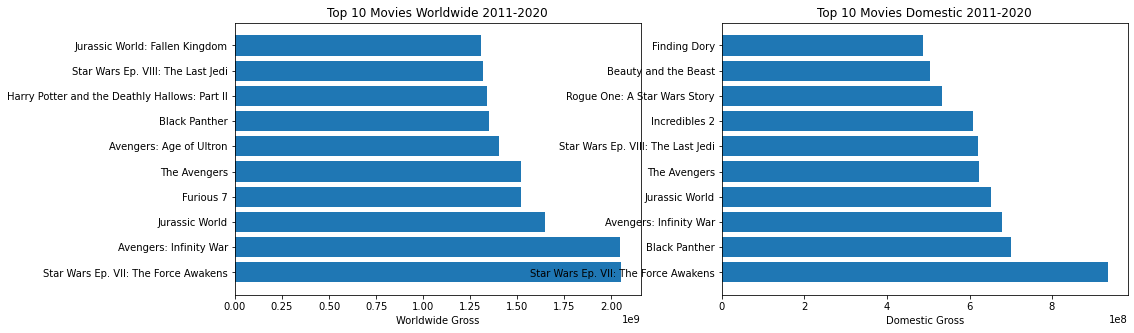

In [42]:
#ax1 = top10_worldwide.set_index('movie').plot(kind='barh')
#ax2 = top10_domestic.set_index('movie').plot(kind='barh')        


# Set up plots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

# Plot data
ax1.barh(top10_worldwide.index, top10_worldwide["worldwide_gross"])
ax2.barh(top10_domestic.index, top10_domestic["domestic_gross"])

# Customize appearance
ax1.set_xlabel("Worldwide Gross")
ax2.set_xlabel("Domestic Gross")
ax1.set_title("Top 10 Movies Worldwide 2011-2020")
ax2.set_title("Top 10 Movies Domestic 2011-2020");
#ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
#ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);


<BarContainer object of 10 artists>

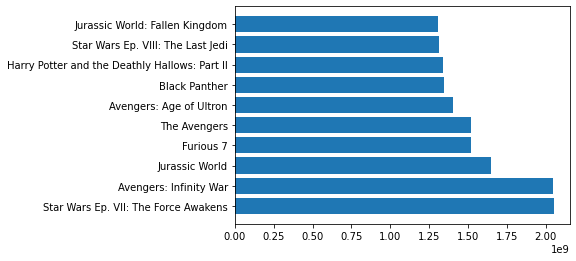

In [43]:
x=top10_worldwide.index
y=top10_worldwide['worldwide_gross']

plt.barh(x, y)

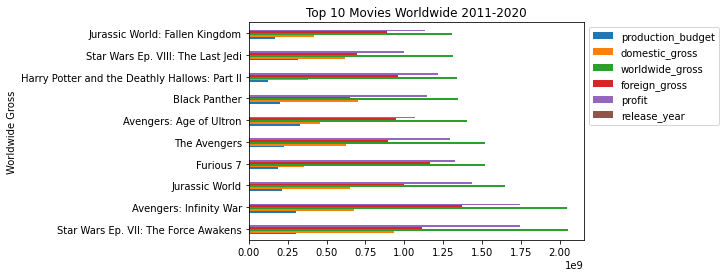

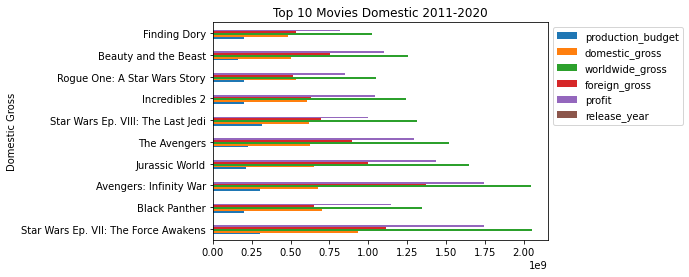

In [44]:
ax1 = top10_worldwide.plot(kind='barh')
ax2 = top10_domestic.plot(kind='barh')        
ax1.set_ylabel("Worldwide Gross")
ax2.set_ylabel("Domestic Gross")
ax1.set_title("Top 10 Movies Worldwide 2011-2020")
ax2.set_title("Top 10 Movies Domestic 2011-2020")
ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

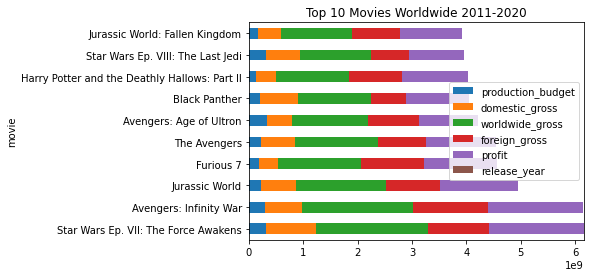

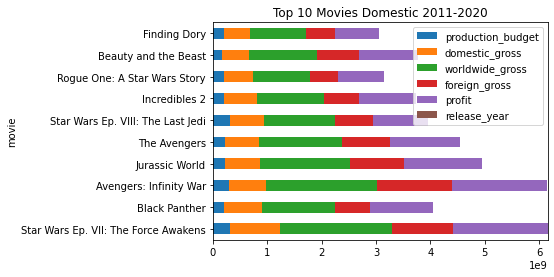

In [45]:
top10_worldwide.plot(kind='barh', stacked=True, title='Top 10 Movies Worldwide 2011-2020')
top10_domestic.plot(kind='barh', stacked=True, title='Top 10 Movies Domestic 2011-2020');

In [46]:
### Answering Q3: Is there any particular director/producer who appears frequently in the above findings?

In [47]:
directors = top10_domestic.explode('primary_name')
directors['primary_name'].value_counts().head()

 Michael Lafuente     2
 Rick James           2
 Doug Mallette        2
 Jerzy Skolimowski    1
 Mahyar Abousaeedi    1
Name: primary_name, dtype: int64

In [48]:
print(f"The directors who appear the most in 'the top 10 movies by domestic gross' are {directors['primary_name'].value_counts().head(3)}.")

The directors who appear the most in 'the top 10 movies by domestic gross' are  Michael Lafuente    2
 Rick James          2
 Doug Mallette       2
Name: primary_name, dtype: int64.


In [49]:
directors_w = top10_worldwide.explode('primary_name')
directors_w['primary_name'].value_counts()

 Doug Mallette         2
 Teo Lee               2
 Robert Pralgo         2
 Daniel S. Kaminsky    2
 Kritteka Gregory      1
                      ..
 Joss Whedon           1
 Nik Kacevski          1
 John K.D. Graham      1
 Vin Diesel            1
 Gregory Bankston      1
Name: primary_name, Length: 108, dtype: int64

In [50]:
print(f"The directors who appear the most in 'the top 10 movies by worldwide gross' are {directors['primary_name'].value_counts().head(4)}.")

The directors who appear the most in 'the top 10 movies by worldwide gross' are  Michael Lafuente     2
 Rick James           2
 Doug Mallette        2
 Jerzy Skolimowski    1
Name: primary_name, dtype: int64.
